# Example: Preparing a data catalog

This example illustrates the how to prepare your own HydroMT [DataCatalog](../_generated/hydromt.data_catalog.DataCatalog.rst) to reference your own data sources and start using then within HydroMT, see [user guide](../guides/advanced_user/data_prepare_cat.rst).

In [1]:
# import python libraries
import os
from pprint import pprint

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray  # noqa
import xarray as xr

import hydromt

The steps to use your own data within HydroMT are in brief:

  1) **Have your (local) dataset ready** in one of the supported [raster](../guides/advanced_user/data_types.rst#raster-data-rasterdataset) (tif, ascii, netcdf, zarr...), 
   [vector](../guides/advanced_user/data_types.rst#vector-data-geodataframe) (shp, geojson, gpkg...) or [geospatial time-series](../guides/advanced_user/data_types.rst#geospatial-point-time-series-geodataset) (netcdf, csv...) format.
  2) **Create your own [yaml file](../guides/advanced_user/data_prepare_cat.rst#data-catalog-yaml-file)** with a reference to your prepared dataset and properties (path, data_type, driver, etc.) following the HydroMT [data conventions](../guides/user_guide/data_conventions.rst#data-conventions). For this step, you can also start from an existing pre-defined catalog or use it for inspiration.

The existing pre-defined catalog are:

In [2]:
# this download the artifact_data archive v1.0.0
data_catalog = hydromt.DataCatalog(data_libs=["artifact_data=v1.0.0"])
pprint(data_catalog.predefined_catalogs)

{'artifact_data': <hydromt.data_catalog.predefined_catalog.ArtifactDataCatalog object at 0x7dddbaf51250>,
 'aws_data': <hydromt.data_catalog.predefined_catalog.AWSDataCatalog object at 0x7ddcf854ff40>,
 'deltares_data': <hydromt.data_catalog.predefined_catalog.DeltaresDataCatalog object at 0x7dddbaf51520>,
 'gcs_cmip6_data': <hydromt.data_catalog.predefined_catalog.GCSCMIP6DataCatalog object at 0x7ddcf854fb20>}


In this notebook, we will see how we can create a data catalog for several type of input data. For this we have prepared several type of data that we will catalogue, let's see which data we have available:

In [3]:
# the artifact data is stored in the following location
root = os.path.join(data_catalog._cache_dir, "artifact_data", "v1.0.0")
# let's print some of the file that are there
for item in os.listdir(root)[-10:]:
    print(item)

gadm_level2.gpkg
gswo.tif
ghs_pop_2015.tif
gadm_level1.gpkg
ghs-smod_2015_v2.tif
gcn250
glw_pigs.tif
chelsa.tif
gtsmv3_eu_era5.nc
merit_hydro_1k


## RasterDataset from raster file

The first file we will use is a 'simple' raster file in a tif format: **vito.tif**. This file contains a landuse classification raster. The first thing to do before adding a new file to a data catalog is to get to know what is inside of our file mainly:

  - **location of the file**: `path`.
  - **type of data**: `data_type`. `RasterDataset` for gridded data, `GeoDataFrame` for vector data, `GeoDataset` for point timeseries and `DataFrame` for tabular data.
  - **file format**: `driver`. The file format impacts the driver or python function that will be used to open the data. Either `raster`, `raster_tindex`, `netcdf`, `zarr`, `vector`, `vector_table`.
  - **crs**: `crs`. Coordinate sytem of the data. Optional as it is usually encoded in the data itself.
  - **variables and their properties**: `rename`, `unit_mult`, `unit_add`. Looking at the variables in the input data and what are their names and units so that we can convert them to the [HydroMT data conventions](../guides/user_guide/data_conventions.rst).
  
There are more arguments or properties to look for that are explained in more detailed in the [documentation](../guides/advanced_user/data_prepare_cat.rst). To discover our data we can either use GIS software like QGIS or GDAL or just use python directly to try and open the data.

Let's open our vito.tif file with xarray and rioxarray:

<xarray.DataArray 'band_data' (band: 1, y: 1613, x: 1412)> Size: 9MB
[2277556 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 11kB 11.6 11.6 11.6 11.6 ... 13.0 13.0 13.0 13.0
  * y            (y) float64 13kB 46.8 46.8 46.8 46.8 ... 45.2 45.2 45.2 45.2
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:  Area
CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


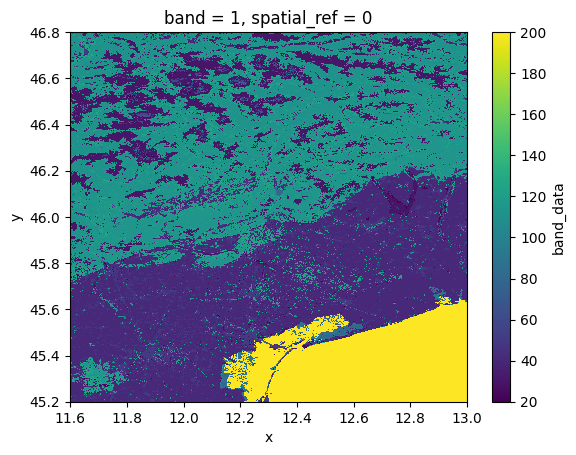

In [4]:
da = xr.open_dataarray(os.path.join(root, "vito.tif"))
pprint(da)
print(f"CRS: {da.raster.crs}")
da.plot()

What we see is that we have a simple raster with landuse data in crs 4326. Let's translate what we know into a data catalog.

In [5]:
yml_str = f"""
meta:
  roots: 
    - {root}
  
vito:
    uri: vito.tif
    data_type: RasterDataset
    driver: 
      name: rasterio 
    metadata:
      crs: 4326 
"""
yaml_path = "tmpdir/vito.yml"
with open(yaml_path, mode="w") as f:
    f.write(yml_str)

And let's now see if HydroMT can properly read the file from the data catalog we prepared:

In [6]:
data_catalog = hydromt.DataCatalog(data_libs=[yaml_path])
da = data_catalog.get_rasterdataset("vito")
da

<xarray.DataArray 'vito' (y: 1613, x: 1412)> Size: 2MB
dask.array<getitem, shape=(1613, 1412), dtype=uint8, chunksize=(1613, 1412), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 11kB 11.6 11.6 11.6 11.6 ... 13.0 13.0 13.0 13.0
  * y            (y) float64 13kB 46.8 46.8 46.8 46.8 ... 45.2 45.2 45.2 45.2
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    source_file:    vito.tif

## RasterDataset from several raster files

The second file we will add is the **merit_hydro** which consists of elevation and elevation-derived variables stored in several tif files for each variable.  Let's see what are their names.

In [7]:
folder_name = os.path.join(root, "merit_hydro")
# let's see which files are there
for path, _, files in os.walk(folder_name):
    print(path)
    for name in files:
        print(f" - {name}")

/home/sam/.hydromt/artifact_data/v1.0.0/merit_hydro
 - flwdir.tif
 - uparea.tif
 - lndslp.tif
 - basins.tif
 - rivwth.tif
 - elevtn.tif
 - upgrid.tif
 - strord.tif
 - hnd.tif


We have here 9 files. When reading tif files, the name of the file is used as the variable name. HydroMT uses data conventions to ensure that certain variables should have the same name and units to be used in automatically in the workflows. For example elevation data should be called *elevtn* with unit in [m asl]. Check the [data conventions](../guides/user_guide/data_conventions.rst) and see if you need to ``rename`` or change units with ``unit_add`` and ``unit_mult`` for this dataset in the data catalog. 

Here all names and units are correct, so we just show an example were we rename the *hnd* variable.

In [8]:
yml_str = f"""
meta:
  roots: 
  - {root}

merit_hydro:
  data_type: RasterDataset
  driver: 
    name: rasterio
    options:
      chunks:
        x: 6000
        y: 6000
      rename:
        hnd: height_above_nearest_drain
  uri: merit_hydro/*.tif
"""
# overwrite data catalog
data_lib = "tmpdir/merit_hydro.yml"
with open(data_lib, mode="w") as f:
    f.write(yml_str)

In [9]:
data_catalog.from_yml(data_lib)  # add a yaml file to the data catalog
print(data_catalog.sources.keys())
ds = data_catalog.get_rasterdataset("merit_hydro")
ds

dict_keys(['vito', 'merit_hydro'])


<xarray.Dataset> Size: 97MB
Dimensions:      (x: 1680, y: 1920)
Coordinates:
  * x            (x) float64 13kB 11.6 11.6 11.6 11.6 ... 13.0 13.0 13.0 13.0
  * y            (y) float64 15kB 46.8 46.8 46.8 46.8 ... 45.2 45.2 45.2 45.2
    spatial_ref  int64 8B 0
Data variables:
    uparea       (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    basins       (y, x) uint32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    flwdir       (y, x) uint8 3MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    strord       (y, x) uint8 3MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    elevtn       (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    upgrid       (y, x) int32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    hnd          (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    lndslp       (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    rivwth       (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>

In the ``path``, the filenames can be further specified with *{variable}*, *{year}* and *{month}* keys to limit which files are being read based on the get_data request in the form of *"path/to/my/files/{variable}_{year}_{month}.nc"*. 

Let's see how this works:

In [10]:
# NOTE: the double curly brackets will be printed as single brackets in the text file
yml_str = f"""
meta:
  roots: 
  - {root}

merit_hydro:
  data_type: RasterDataset
  driver: 
    name: rasterio
    options:
      chunks:
        x: 6000
        y: 6000
  data_adapter:
    rename:
      hnd: height_above_nearest_drain
  uri: merit_hydro/{{variable}}.tif
"""
# overwrite data catalog
data_lib = "tmpdir/merit_hydro.yml"
with open(data_lib, mode="w") as f:
    f.write(yml_str)

In [11]:
data_catalog.from_yml(data_lib)  # add a yaml file to the data catalog
print(data_catalog.sources.keys())
ds = data_catalog.get_rasterdataset(
    "merit_hydro", variables=["height_above_nearest_drain", "elevtn"]
)
ds

overwriting data source 'merit_hydro' with provider file and version _UNSPECIFIED_.


dict_keys(['vito', 'merit_hydro'])


<xarray.Dataset> Size: 26MB
Dimensions:                     (y: 1920, x: 1680)
Coordinates:
  * x                           (x) float64 13kB 11.6 11.6 11.6 ... 13.0 13.0
  * y                           (y) float64 15kB 46.8 46.8 46.8 ... 45.2 45.2
    spatial_ref                 int64 8B 0
Data variables:
    height_above_nearest_drain  (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>
    elevtn                      (y, x) float32 13MB dask.array<chunksize=(1920, 1680), meta=np.ndarray>

## RasterDataset from a netcdf file

The last RasterDataset file we will add is the **era5.nc** which consists of climate variables stored in a netcdf file.  Let's open this file with xarray.

In [12]:
ds = xr.open_dataset(os.path.join(root, "era5.nc"))
pprint(ds)

<xarray.Dataset> Size: 17kB
Dimensions:      (time: 14, latitude: 7, longitude: 6)
Coordinates:
  * time         (time) datetime64[ns] 112B 2010-02-01 2010-02-02 ... 2010-02-14
  * longitude    (longitude) float32 24B 11.75 12.0 12.25 12.5 12.75 13.0
  * latitude     (latitude) float32 28B 46.75 46.5 46.25 46.0 45.75 45.5 45.25
    spatial_ref  int32 4B ...
Data variables:
    precip       (time, latitude, longitude) float32 2kB ...
    temp         (time, latitude, longitude) float32 2kB ...
    press_msl    (time, latitude, longitude) float32 2kB ...
    kin          (time, latitude, longitude) float32 2kB ...
    kout         (time, latitude, longitude) float32 2kB ...
    temp_min     (time, latitude, longitude) float32 2kB ...
    temp_max     (time, latitude, longitude) float32 2kB ...
Attributes:
    category:        meteo
    history:         Extracted from Copernicus Climate Data Store; resampled ...
    paper_doi:       10.1002/qj.3803
    paper_ref:       Hersbach et al. (20

Text(0.5, 1.0, 'press_msl')

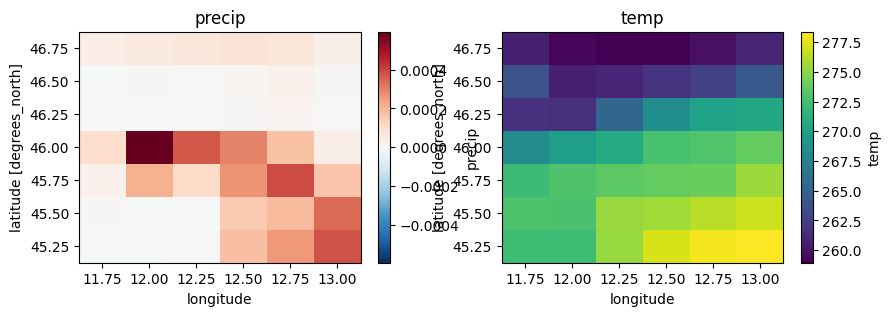

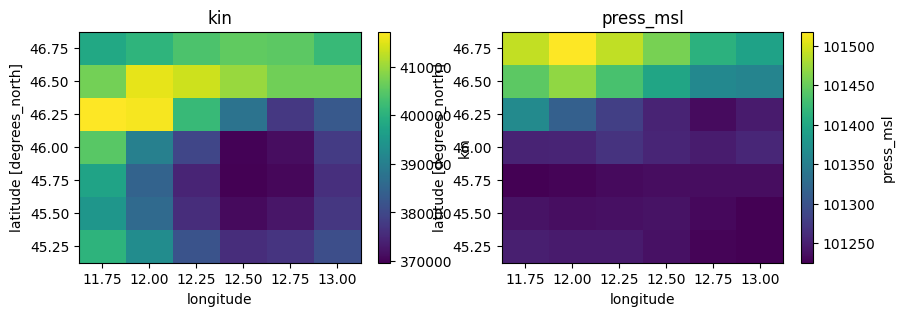

In [13]:
# Select first timestep
ds1 = ds.sel(time=ds.time[0])
ds1
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ds1["precip"].plot(ax=axes[0])
axes[0].set_title("precip")
ds1["temp"].plot(ax=axes[1])
axes[1].set_title("temp")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ds1["kin"].plot(ax=axes[0])
axes[0].set_title("kin")
ds1["press_msl"].plot(ax=axes[1])
axes[1].set_title("press_msl")

Checking the [data conventions](../guides/user_guide/data_conventions.rst) we see that all variables already have the right names but the units should be changed:

  - precip from m to mm
  - temp, temp_min, temp_max from K to C
  - kin, kout from J.m-2 to W.m-2
  - press_msl from Pa to hPa

Let's change the units using ``unit_mult`` and ``unit_add``:

In [14]:
yml_str = f"""
meta:
  roots: 
  - {root}

era5:
  metadata:
    crs: 4326
  data_type: RasterDataset
  driver: 
    name: raster_xarray
  data_adapter:
    unit_add:
      temp: -273.15
      temp_max: -273.15
      temp_min: -273.15
      time: 86400
    unit_mult:
      kin: 0.000277778
      kout: 0.000277778
      precip: 1000
      press_msl: 0.01

  uri: era5.nc
  
"""
# overwrite data catalog
data_lib = "tmpdir/era5.yml"
with open(data_lib, mode="w") as f:
    f.write(yml_str)

And now open our dataset and check the units have been converted.

In [15]:
data_catalog.from_yml(data_lib)  # add a yaml file to the data catalog
print(data_catalog.sources.keys())
ds = data_catalog.get_rasterdataset("era5")
ds

object: RasterDatasetXarrayDriver does not use kwarg metadata with value crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 unit=None extent={} nodata=None attrs={} category=None.


dict_keys(['vito', 'merit_hydro', 'era5'])


<xarray.Dataset> Size: 17kB
Dimensions:      (time: 14, latitude: 7, longitude: 6)
Coordinates:
  * time         (time) datetime64[ns] 112B 2010-02-02 2010-02-03 ... 2010-02-15
  * longitude    (longitude) float32 24B 11.75 12.0 12.25 12.5 12.75 13.0
  * latitude     (latitude) float32 28B 46.75 46.5 46.25 46.0 45.75 45.5 45.25
    spatial_ref  int32 4B ...
Data variables:
    precip       (time, latitude, longitude) float32 2kB dask.array<chunksize=(14, 7, 6), meta=np.ndarray>
    temp         (time, latitude, longitude) float32 2kB dask.array<chunksize=(14, 7, 6), meta=np.ndarray>
    press_msl    (time, latitude, longitude) float32 2kB dask.array<chunksize=(14, 7, 6), meta=np.ndarray>
    kin          (time, latitude, longitude) float32 2kB dask.array<chunksize=(14, 7, 6), meta=np.ndarray>
    kout         (time, latitude, longitude) float32 2kB dask.array<chunksize=(14, 7, 6), meta=np.ndarray>
    temp_min     (time, latitude, longitude) float32 2kB dask.array<chunksize=(14, 7, 6), meta=np.ndarray>
    temp_max     (time, latitude, longitude) float32 2kB dask.array<chunksize=(14, 7, 6), meta=np.ndarray>
Attributes:
    category:        meteo
    history:         Extracted from Copernicus Climate Data Store; resampled ...
    paper_doi:       10.1002/qj.3803
    paper_ref:       Hersbach et al. (2019)
    source_license:  https://cds.climate.copernicus.eu/cdsapp/#!/terms/licenc...
    source_url:      https://doi.org/10.24381/cds.bd0915c6
    source_version:  ERA5 daily data on pressure levels
    crs:             4326

Text(0.5, 1.0, 'press_msl')

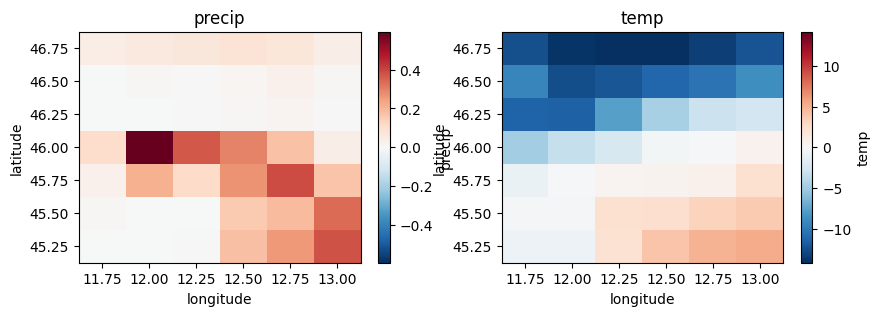

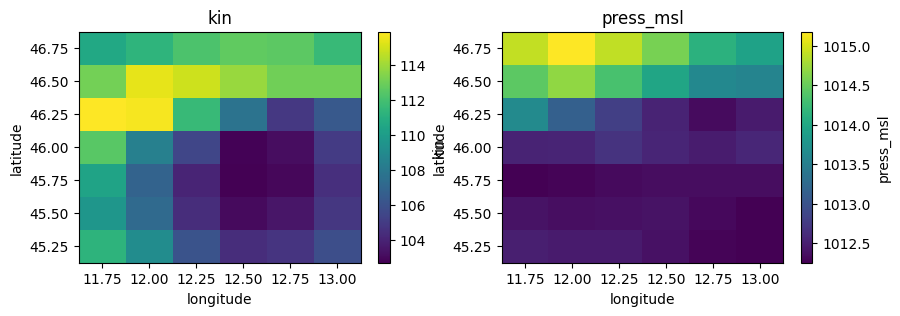

In [16]:
# Select first timestep
ds1 = ds.sel(time=ds.time[0])
ds1
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ds1["precip"].plot(ax=axes[0])
axes[0].set_title("precip")
ds1["temp"].plot(ax=axes[1])
axes[1].set_title("temp")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ds1["kin"].plot(ax=axes[0])
axes[0].set_title("kin")
ds1["press_msl"].plot(ax=axes[1])
axes[1].set_title("press_msl")

## GeoDataFrame from a vector file

Now we will see how to add vector data to the data catalogue based on **rivers_lin2019_v1.gpkg**. Vector files can be open in Python with geopandas (or you can use QGIS) to inspect the data.

      COMID  order         area       Sin       Slp       Elev             K  \
0  21002594    4.0  1788.131052  1.527056  0.000451  10.648936  3.020000e-11   
1  21002602    4.0  1642.386086  1.733917  0.000225  15.861538  3.020000e-11   
2  21002675    4.0  2041.630090  1.212651  0.000071   0.975904  3.020000e-11   
3  21002937    2.0   258.144582  1.226202  0.000056   1.922830  3.020000e-11   
4  21002680    4.0  1983.584528  1.225684  0.000076   1.892537  3.020000e-11   

     P        AI       LAI  ...        SLT        Urb       WTD        HW  \
0  0.0  0.795613  1.204846  ...  40.403226  46.983871  1.087777  2.501222   
1  0.0  0.828527  1.327503  ...  42.454545  18.181818  4.564060  1.769275   
2  0.0  0.662288  0.295892  ...  44.437500  11.250000  0.352534  1.354830   
3  0.0  0.726821  1.181066  ...  43.711538  15.634615  1.570532  1.671508   
4  0.0  0.719180  1.146002  ...  42.900000  18.900000  0.342745  1.487189   

   DOR      QMEAN   qbankfull      rivwth   width_DHG  \

<Axes: >

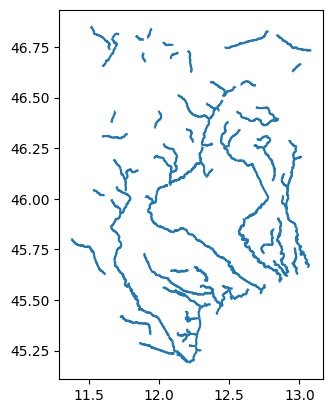

In [17]:
gdf = gpd.read_file(os.path.join(root, "rivers_lin2019_v1.gpkg"))
pprint(gdf.head())
print(f"Variables: {gdf.columns}")
print(f"CRS: {gdf.crs}")
gdf.plot()

This data source contains rivers line including attributes that can be usefull to setup models such as river width, average discharge or bankfull discharge. Here it's not needed but feel free to try out some renaming or unit conversion. The minimal data catalog input would be:

In [18]:
yml_str = f"""
meta:
  roots: 
    - {root}

rivers_lin:
  data_type: GeoDataFrame
  driver: 
    name: pyogrio
  uri: rivers_lin2019_v1.gpkg
"""
# overwrite data catalog
data_lib = "tmpdir/rivers.yml"
with open(data_lib, mode="w") as f:
    f.write(yml_str)

In [19]:
data_catalog.from_yml(data_lib)  # add a yaml file to the data catalog
print(data_catalog.sources.keys())
gdf = data_catalog.get_geodataframe("rivers_lin")

object: PyogrioDriver does not use kwarg predicate with value intersects.


object: PyogrioDriver does not use kwarg metadata with value crs=None unit=None extent={} nodata=None attrs={} category=None.


dict_keys(['vito', 'merit_hydro', 'era5', 'rivers_lin'])


## GeoDataset from a netcdf file

Now we will see how to add geodataset data to the data catalogue based on **gtsmv3_eu_era5.nc**. This geodataset file contains ocean water level timeseries at specific stations locations in netdcf format and can be opened in Python with xarray. In HydroMT we use a specific wrapper around xarray called GeoDataset to mark that this file contains geospatial timeseries, in this case point timeseries. But for now we can inspect it with xarray.

To learn more about GeoDataset type you can check the [reading geodataset example](reading_point_data.ipynb).

In [20]:
ds = xr.open_dataset(os.path.join(root, "gtsmv3_eu_era5.nc"))
ds

<xarray.Dataset> Size: 323kB
Dimensions:      (stations: 19, time: 2016)
Coordinates:
    lon          (stations) float64 152B ...
  * time         (time) datetime64[ns] 16kB 2010-02-01 ... 2010-02-14T23:50:00
    lat          (stations) float64 152B ...
    spatial_ref  int32 4B ...
  * stations     (stations) int32 76B 13670 2798 2799 13775 ... 2791 2790 2789
Data variables:
    waterlevel   (time, stations) float64 306kB ...

This is quite a classic file, so the data catalog entry is quite straightforward:

In [21]:
yml_str = f"""
meta:
  roots: 
    - {root}

gtsm:
  data_type: GeoDataset
  driver: 
    name: geodataset_xarray
  metadata:
    crs: 4326
    category: ocean
    source_version: GTSM v3.0
  uri: gtsmv3_eu_era5.nc
"""
# overwrite data catalog
data_lib = "tmpdir/gtsm.yml"
with open(data_lib, mode="w") as f:
    f.write(yml_str)

In [22]:
data_catalog.from_yml(data_lib)  # add a yaml file to the data catalog
print(data_catalog.sources.keys())
ds = data_catalog.get_geodataset("gtsm")
ds

object: GeoDatasetXarrayDriver does not use kwarg predicate with value intersects.


dict_keys(['vito', 'merit_hydro', 'era5', 'rivers_lin', 'gtsm'])


<xarray.DataArray 'waterlevel' (time: 2016, stations: 19)> Size: 306kB
dask.array<open_dataset-waterlevel, shape=(2016, 19), dtype=float64, chunksize=(2016, 19), chunktype=numpy.ndarray>
Coordinates:
    lon          (stations) float64 152B dask.array<chunksize=(19,), meta=np.ndarray>
  * time         (time) datetime64[ns] 16kB 2010-02-01 ... 2010-02-14T23:50:00
    lat          (stations) float64 152B dask.array<chunksize=(19,), meta=np.ndarray>
    spatial_ref  int32 4B ...
  * stations     (stations) int32 76B 13670 2798 2799 13775 ... 2791 2790 2789
Attributes:
    long_name:       sea_surface_height_above_mean_sea_level
    units:           m
    CDI_grid_type:   unstructured
    short_name:      waterlevel
    description:     Total water level resulting from the combination of baro...
    category:        ocean
    paper_doi:       10.24381/cds.8c59054f
    paper_ref:       Copernicus Climate Change Service 2019
    source_license:  https://cds.climate.copernicus.eu/cdsapp/#!/terms/licenc...
    source_url:      https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24...
    source_version:  GTSM v3.0

## GeoDataset from vector files

For geodataset, you can also use the ``vector`` driver to combine two files, one for the location and one for the timeseries into one geodataset. We have a custom example available in the data folder of our example notebook using the files *stations.csv* for the locations and *stations_data.csv* for the timeseries:

In [23]:
# example data folder
root_data = "data"
# let's print some of the file that are there
for item in os.listdir(root_data):
    print(item)

tabular_data_catalog.yml
mesh_model
stations_data.csv
discharge.nc
vito_reclass.yml
vito_reclass.csv
geodataset_catalog.yml
example_csv_data.csv
stations.csv


For this driver to work, the format of the timeseries table is quite strict (see [docs](../guides/advanced_user/data_types.rst#csv-point-time-series-data)). Let's inspect the two files using pandas in python:

In [24]:
df_locs = pd.read_csv("data/stations.csv")
pprint(df_locs)

   stations         x         y
0      1001  12.50244  45.25635
1      1002  12.75879  45.24902


In [25]:
df_data = pd.read_csv("data/stations_data.csv")
pprint(df_data)

            time      1001      1002
0     2016-01-01  0.590860  0.591380
1     2016-01-02  0.565552  0.571342
2     2016-01-03  0.538679  0.549770
3     2016-01-04  0.511894  0.526932
4     2016-01-05  0.483989  0.502907
...          ...       ...       ...
2011  2021-07-04  0.271673  0.287093
2012  2021-07-05  0.249286  0.265656
2013  2021-07-06  0.224985  0.243299
2014  2021-07-07  0.199994  0.220004
2015  2021-07-08  0.174702  0.196587

[2016 rows x 3 columns]


And see how the data catalog would look like:

In [26]:
yml_str = f"""
meta:
  roots: 
    - {os.path.join(os.getcwd(), 'data')}

waterlevel_csv:
  metadata:
    crs: 4326
  data_type: GeoDataset
  driver:
    name: geodataset_vector
    options:
      data_path: stations_data.csv
  uri: stations.csv
  data_adapter:
    rename:
      stations_data: waterlevel

"""
# overwrite data catalog
data_lib = "tmpdir/waterlevel.yml"
with open(data_lib, mode="w") as f:
    f.write(yml_str)

In [27]:
data_catalog.from_yml(data_lib)  # add a yaml file to the data catalog
print(data_catalog.sources.keys())
ds = data_catalog.get_geodataset("waterlevel_csv")
ds

object: GeoDatasetVectorDriver does not use kwarg metadata with value crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 unit=None extent={} nodata=None attrs={} category=None.


dict_keys(['vito', 'merit_hydro', 'era5', 'rivers_lin', 'gtsm', 'waterlevel_csv'])


<xarray.DataArray 'waterlevel' (stations: 2, time: 2016)> Size: 32kB
dask.array<xarray-stations_data, shape=(2, 2016), dtype=float64, chunksize=(2, 2016), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 16kB 2016-01-01 2016-01-02 ... 2021-07-08
  * stations     (stations) int64 16B 1001 1002
    geometry     (stations) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    spatial_ref  int64 8B 0